In [2]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from util import skill_matrix, build_h_matrix
from util import reverse_vector, forecast_ssh
from util import build_swath, inversion, inversion2, make_error_over_time
import glob2 as glob


day0, day1 = 0, 40 # 
Tdim = day1 - day0
time_range = 2 * Tdim
start_date = '2016-01-01' ## starting date
n_waves = '190' #number of waves
exp = 1 # P_over_R = K^-1
MModes = 1 # Rossby wave vertical modes
wave_files = glob.glob('./rossby_wave_estimate_*_' + n_waves + 'waves_data40days.nc')
wave_files = sorted(wave_files)

alpha_std = np.arange(5e-4, 3.05e-2, 1e-3) # standard deviation of error paramters

lonidx_west, lonidx_east  =  60, 102
latidx_south, latidx_north = 34, 74

avisso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
# stg:  commented out the next line since SSHA appears not to be used
#SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]
# stg:  added the following line to remove mean over study period to produce anomaly.  commented out since not used
#SSHA = SSHA-SSHA[:].mean(axis = -1)
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
date_time = avisso_ds.date_time.data[day0:]


# Initialize arrays
rms_err, rms_ssh = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
ssh_est_skill2, err_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
ssh_est_skill1, err_est_skill1 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

# Initialize arrays for storing forecasts and variance explained
SSHA_predicted = np.zeros( (len(wave_files), len(alpha_std), time_range, len(lat) * len(lon)))
SSHA_predicted1 = np.zeros( (len(wave_files), len(alpha_std), time_range, len(lat) * len(lon)))
variance_explained_1step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_2step = np.zeros((len(wave_files),len(alpha_std), time_range))
MSLA_fwrd_1step = np.zeros((len(wave_files), len(alpha_std), len(lat), len(lon), time_range))
MSLA_fwrd_2step = np.zeros((len(wave_files), len(alpha_std), len(lat), len(lon), time_range))

# Initialize multi-dimensional arrays for storing variance explained
variance_explained_in_1step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_out_1step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_in_2step = np.zeros((len(wave_files), len(alpha_std), time_range))
variance_explained_out_2step = np.zeros((len(wave_files), len(alpha_std), time_range))

with tqdm(total= rms_err.size) as pbar:
    for n in range(len(wave_files)):
        wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
        l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
        amp = wave_ds.Amplitudes.data
        time= wave_ds.time.data
        MSLA_fwd = wave_ds.MSLA_forward.data
        Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree
        l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
        amp = wave_ds.Amplitudes.data
        time= wave_ds.time.data
        MSLA_fwd = wave_ds.MSLA_forward.data
        Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree
        Phi0 = lat.mean() # central latitude (φ0)
        Omega = 7.27e-5 # Ω is the angular speed of the earth
        Earth_radius = 6.371e6 / 1e5 # meters
        Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
        f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

        strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
        Psi = strat_ds.Psi.data

        l_n = l_n_orig.reshape(len(l_n_orig), MModes)
        k_n = k_n_orig.reshape(len(k_n_orig), MModes)

        MSLA0 = MSLA_fwd[:, :, day0:day1]

        ### assess skill, get indices
        skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

        M = k_n.size * l_n.size # Number of models/waves

        dlon = lon - lon.mean()
        dlat = lat - lat.mean()

        H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
        H_all = np.zeros([len(SSHA_vector), M * 2])
        omega = np.zeros([len(k_n), len(l_n), MModes])

        nn = 0
        for kk in range(len(k_n)):
            for ll in range(len(l_n)):
                for mm in range(MModes):
                    omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (l_n[ll, mm] ** 2 + k_n[kk, mm] ** 2 + Rm ** -2)
                    for count in range(len(Iindex)):
                        # (data, model)
                        H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
                        H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
                    nn += 1

        H_all[:, 0::2] = H_cos
        H_all[:, 1::2] = H_sin

        # signal to noise ratio R_over_P

        counter = 0
        exp = -2
        ssh_std = .1
        k0 = l_n.max() # flat at or below k0

        p_diagonal = np.zeros([2 * M])
        kl, kl_plot = np.zeros(M), np.zeros(2*M)
        k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
        counter = 0
        R = 0.01 # noise = 1. cm

        for kk in l_n:
            for ll in k_n:
                k_[counter] , l_[counter]  = kk, ll
                kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
                kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
                p_diagonal[2 * counter] = (kl[counter]+k0) ** exp
                p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp
                counter += 1

        P_matrix = np.zeros([2 * M, 2 * M])
        p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
        np.fill_diagonal(P_matrix[:],  R / p_diagonal / p_factor)

        ## build satellite swath

        swath_width, x_swath = 6, 20
        days = np.arange(day0, day1)
        xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

        # Loop over sigma
        sigma_counter = 0
        
        for sigma in alpha_std: # std of error amp

            # Add errors to the swaths
            mu = 0
            time_factor = np.arange(1, 1 + day1-day0)
            # generate error parameter with Gaussian distribution
            alpha = np.zeros([Tdim, 7, 2]) #np.random.normal(mu, sigma, Tdim * 7).reshape(Tdim, 7) #
            for lr in range(2):
                for nn in range(7):
                    alpha[:, nn, lr] = np.random.normal(mu, sigma, Tdim) #TEST

            timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

            # sample SSH, errors and add white noise
            IND_TIMINGl = -7
            IND_ROLLl = -6
            IND_BASELINEl = -5
            IND_PHASE3l, IND_PHASE4l, IND_PHASE5l, IND_PHASE6l = -4, -3, -2, -1
            # sample SSH, errors and add white noise
            IND_TIMINGr = -7
            IND_ROLLr = -6
            IND_BASELINEr = -5
            IND_PHASE3r, IND_PHASE4r, IND_PHASE5r, IND_PHASE6r = -4, -3, -2, -1

            #### Sub-sample the SSH, correlated errors and H matrix
            N = len(tindex) # number of data
            MSLA_swath = np.zeros(N)
            M = l_n.size * k_n.size
            nx, ny = len(lon), len(lat)
            H_swath = np.zeros([N, 2 * M + Tdim * 7*2]) # M: number of model
            IIndex = np.zeros(N) # N: Number of y data
            cor_err = np.zeros(N) # Correlated Error N: Number of y data
            Y_v = np.zeros(N)
            ssh = np.zeros(N)
            mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1],MSLA_fwd.shape[2]])

            for ii in range(N):
                IIndex[ii] = nx * ny * tindex[ii] + ny * xvalid_index[ii] + yvalid_index[ii] # index in the vector space
                ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
                cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
                MSLA_swath[ii] = ssh[ii] + cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
                mask[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])] = 1
                for nn in range(M):
                    JIndex = 2 * MModes * nn # +  2 * mm # Model space
                    H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
                    H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

            left_valid = len(yswath_index_left.compressed().astype(int))
            right_valid = len(yswath_index_right.compressed().astype(int)) 
            Valid_points = len(xvalid_index) // Tdim
            err_basis_func = np.zeros([Valid_points, 7*2])
            
            tt=0
            for tt in range(Tdim):
                
                for ii in range(left_valid):
                    #timing error
                    err_basis_func[ii, IND_TIMINGl] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
                    # roll error = alpha[1] * Xc^1
                    err_basis_func[ii, IND_ROLLl] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
                    # baseline dialation error = alpha[2] * Xc^2
                    err_basis_func[ii, IND_BASELINEl] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc
                    # phase error
                    H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
                    H_pos = np.heaviside(xc1_valid[tt, ii], 1) #
                    err_basis_func[ii, IND_PHASE3l] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
                    err_basis_func[ii, IND_PHASE4l] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
                    err_basis_func[ii, IND_PHASE5l] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
                    err_basis_func[ii, IND_PHASE6l] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

                for ii in range(left_valid,Valid_points):
                    #timing error
                    err_basis_func[ii, IND_TIMINGr] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
                    # roll error = alpha[1] * Xc^1
                    err_basis_func[ii, IND_ROLLr] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
                    # baseline dialation error = alpha[2] * Xc^2
                    err_basis_func[ii, IND_BASELINEr] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
                    # phase error 
                    H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
                    H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
                    err_basis_func[ii, IND_PHASE3r] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
                    err_basis_func[ii, IND_PHASE4r] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
                    err_basis_func[ii, IND_PHASE5r] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
                    err_basis_func[ii, IND_PHASE6r] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
                
                ### fill the error basis function part of the H matrix
                H_swath[tt*Valid_points:(tt+1)*Valid_points, 2 * M + tt * 7*2 : 2 * M + (tt+1) * 7*2] = err_basis_func
  
            
            counter = 0
            exp = -2
            ssh_std = .1
            k0 = l_n.max() # flat at or below k0
            p_diagonal = np.zeros([2 * M + Tdim * 7*2])
            kl, kl_plot = np.zeros(M), np.zeros(2*M)
            k_, l_ = np.zeros(M), np.zeros(M)
            counter = 0
            R = 0.01 # noise = 10. cm

            for kk in l_n:
                for ll in k_n:
                    k_[counter] , l_[counter]  = kk, ll
                    kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
                    kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
                    p_diagonal[2 * counter] = (kl[counter] + k0) ** exp  * p_factor
                    p_diagonal[2 * counter + 1] = (kl[counter] + k0) ** exp  * p_factor
                    counter += 1

            p_diagonal[2*M:] = sigma ** 2 # errors

            P_matrix = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])

            np.fill_diagonal(P_matrix[:],  R / p_diagonal )

            Y_vector = Y_v
            H_matrix = H_swath

            # 1-stage approach, solve for amplitudes
            amp_swath, msla_estimated_swath = inversion(MSLA_swath, H_swath, P_matrix) # assimilate the filtered AVISO SSH + error

            # estimate the errors and ssh : H * amp
            err_est_1step = np.matmul(H_matrix[:, -7*2*Tdim:], amp_swath[-7*2*Tdim:])
            ssh_est_1step = np.matmul(H_matrix[:, :-7*2*Tdim], amp_swath[:-7*2*Tdim])

            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff = ssh_est_1step - ssh
            err_diff = err_est_1step - cor_err
            ssh_diff1 = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
            err_diff1  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

            HTH = np.matmul(H_matrix[:, -7 *2* Tdim:].T, H_matrix[:, -7 *2* Tdim:])

            # Two-stage approach: reconstructing the SSH separately from solving the correlated error

            # First step: fit errors
            H_v1 = H_swath[:, -7 *2* Tdim:]
            P_over_R1 = P_matrix[-7*2* Tdim:, -7*2* Tdim:]
            HTH = np.matmul(H_v1.T, H_v1)
            HRH = HTH + P_over_R1 # P: uncertainty in model, R: uncertainty in data
            D = np.matmul(LA.inv(HRH), H_v1.T)
            amp_err = np.matmul(D, MSLA_swath)

            err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error

            # second step: fit residual to rossby wave models

            H_v = H_swath[:, :-7 *2* Tdim]
            HTH = np.matmul(H_v.T, H_v)
            HRH = np.zeros(HTH.shape)
            HRH = HTH +  P_matrix[:-7 *2* Tdim, :-7 *2* Tdim]
            D = np.matmul(LA.inv(HRH), H_v.T)
            eig, vec = LA.eig(HRH)

            # second step: fit residual to rossby wave models
            tau_ssh = MSLA_swath - err_est_2step
            amp_swath_2step = np.matmul(D, tau_ssh)
            ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_diff = ssh_est_2step - ssh
            err_diff = err_est_2step - cor_err
            ssh_diff_2stage = (np.mean(ssh_diff ** 2)) / (np.mean(ssh ** 2))
            err_diff_2stage = (np.mean(err_diff ** 2)) / (np.mean(cor_err ** 2))

            # Root mean squared err/ssh
            rms_err[n, sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
            rms_ssh[n, sigma_counter]= np.sqrt(np.mean(ssh ** 2))

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2[n, sigma_counter], err_est_skill2[n, sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,

            # Important result: 1-stage error estimate skill and ssh estimate skill
            ssh_est_skill1[n, sigma_counter], err_est_skill1[n, sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 # percentage,

            for day in range(time_range):

                # Extract MSLA for the current day
                MSLA = MSLA_fwd[:, :, day0 + day:day0 + day + 1]

                # Build H matrix for the current MSLA
                H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day)

                # Forecast SSH using 1-stage and 2-stage approaches
                
                # 1-stage approach
                SSHA_predicted1[n, sigma_counter, day], _, variance_explained_1step[n, sigma_counter, day] = forecast_ssh(MSLA, amp_swath[:380], H_all) 
                # Convert vector back to 2-D field
                MSLA_fwrd_1step[n, sigma_counter, :, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted1[n, sigma_counter, day])
                
                # 2-stage approach
                SSHA_predicted[n, sigma_counter, day], _, variance_explained_2step[n, sigma_counter, day] = forecast_ssh(MSLA, amp_swath_2step, H_all) 
                # Convert vector back to 2-D field
                MSLA_fwrd_2step[n, sigma_counter, :, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[n, sigma_counter, day])

                # Masking the in-track and out-of-track data for the current day
                msla_in = np.ma.masked_where(mask[:, :, day] == 0, MSLA_fwd[:, :, day])
                msla_out = np.ma.masked_where(mask[:, :, day] == 1, MSLA_fwd[:, :, day])

                # Apply the same mask to the predicted data
                msla_fwrd_in_1step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_1step[n, sigma_counter, :, :, day])
                msla_fwrd_out_1step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_1step[n, sigma_counter, :, :, day])
                msla_fwrd_in_2step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_2step[n, sigma_counter, :, :, day])
                msla_fwrd_out_2step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_2step[n, sigma_counter, :, :, day])

                # Variance explained (1-step and 2-step)
                variance_explained_in_1step[n, sigma_counter, day] = np.mean((msla_in - msla_fwrd_in_1step)**2) / np.var(msla_in)
                variance_explained_out_1step[n, sigma_counter, day] = np.mean((msla_out - msla_fwrd_out_1step)**2) / np.var(msla_out)
                variance_explained_in_2step[n, sigma_counter, day] = np.mean((msla_in - msla_fwrd_in_2step)**2) / np.var(msla_in)
                variance_explained_out_2step[n, sigma_counter, day] = np.mean((msla_out - msla_fwrd_out_2step)**2) / np.var(msla_out)

            sigma_counter += 1
        
            pbar.update(1)

  0%|                                                 | 0/360 [00:00<?, ?it/s]/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_89360/3371243813.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (l_n[ll, mm] ** 2 + k_n[kk, mm] ** 2 + Rm ** -2)
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_89360/3371243813.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_89360/3371243813.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will e

In [4]:
import numpy as np
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3) # standard deviation of error paramters

In [5]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)

In [6]:
# only show error estimate skill greater than -100%
err_est_skill1 = np.ma.masked_less(err_est_skill1, -100)
err_est_skill2 = np.ma.masked_less(err_est_skill2, -100)

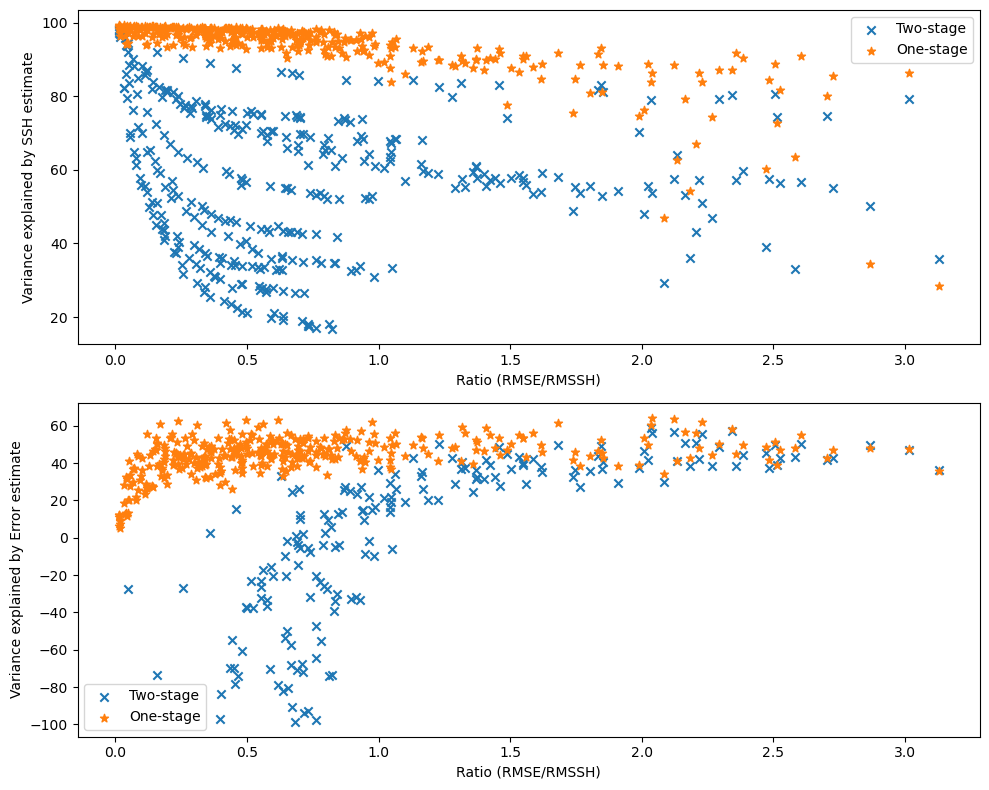

In [7]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh , ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')

axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Variance explained by SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Variance explained by Error estimate')

# Add titles
# axs[0].set_title('Skill in SSH estimate for different RMSE values')
# axs[1].set_title('Skill in Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()
#plt.show()
plt.savefig('skill_ssh_errr_rmse_ratio'+ start_date +'.png', dpi = 300)

In [8]:
MSLA_fwrd_1step.shape

(12, 30, 40, 42, 80)

In [9]:
# Masking the in-track and out-of-track data for the current day

# Loop over sigma
sigma_counter = 0
for sigma in alpha_std: # std of error amp     
    for day in range(time_range):
        
        msla_in = np.ma.masked_where(mask[:, :, day] == 0, MSLA_fwd[:, :, day])
        msla_out = np.ma.masked_where(mask[:, :, day] == 1, MSLA_fwd[:, :, day])

        # Apply the same mask to the predicted data
        msla_fwrd_in_1step = np.ma.masked_where(mask[:, :, day] == 0, MSLA_fwrd_1step[sigma_counter, :, :, day])
        msla_fwrd_out_1step = np.ma.masked_where(mask[:, :, day] == 1, MSLA_fwrd_1step[sigma_counter, :, :, day])
        msla_fwrd_in_2step = np.ma.masked_where(mask[:, :, day] == 0, MSLA_fwrd_2step[sigma_counter, :, :, day])
        msla_fwrd_out_2step = np.ma.masked_where(mask[:, :, day] == 1, MSLA_fwrd_2step[sigma_counter, :, :, day])

        # Variance explained (1-step and 2-step)
        variance_explained_in_1step[sigma_counter, day] = np.mean((msla_in - msla_fwrd_in_1step)**2) / np.var(msla_in)
        variance_explained_out_1step[sigma_counter, day] = np.mean((msla_out - msla_fwrd_out_1step)**2) / np.var(msla_out)
        variance_explained_in_2step[sigma_counter, day] = np.mean((msla_in - msla_fwrd_in_2step)**2) / np.var(msla_in)
        variance_explained_out_2step[sigma_counter, day] = np.mean((msla_out - msla_fwrd_out_2step)**2) / np.var(msla_out)

    sigma_counter += 1

    pbar.update(1)

IndexError: Inconsistent shape between the condition and the input (got (40, 42) and (30, 40, 80))

ValueError: x and y must have same first dimension, but have shapes (80,) and (30, 80)

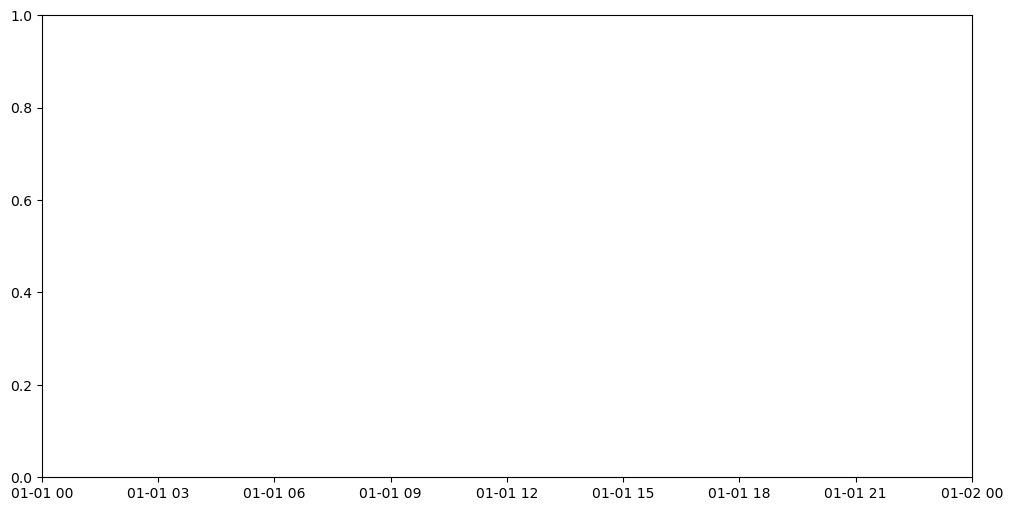

In [10]:
 # Calculate and plot the mean and standard deviation over the 'sigma' dimension for each data array
mean_variance_explained_1step = np.mean(variance_explained_1step, axis=0)
mean_variance_explained_2step = np.mean(variance_explained_2step, axis=0)
mean_variance_explained_in_1step = np.mean(variance_explained_in_1step, axis=0)
mean_variance_explained_out_1step = np.mean(variance_explained_out_1step, axis=0)
mean_variance_explained_in_2step = np.mean(variance_explained_in_2step, axis=0)
mean_variance_explained_out_2step = np.mean(variance_explained_out_2step, axis=0)


# Time array
time_array = time[0:time_range]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive']

# Plot each mean data array
ax.plot(time_array, 100 - mean_variance_explained_1step*100, label='Variance Explained 1 Step', color=colors[0])
ax.plot(time_array, 100 -mean_variance_explained_2step*100, label='Variance Explained 2 Step', color=colors[1])
ax.plot(time_array, 100 -mean_variance_explained_in_1step*100, label='Variance Explained In 1 Step', color=colors[2])
ax.plot(time_array, 100 - mean_variance_explained_out_1step*100, label='Variance Explained Out 1 Step', color=colors[3])
ax.plot(time_array, 100 - mean_variance_explained_in_2step*100, label='Variance Explained In 2 Step', color=colors[4])
ax.plot(time_array, 100 - mean_variance_explained_out_2step*100, label='Variance Explained Out 2 Step', color=colors[5])

# Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Percentage')
ax.set_title('Ensemble Spread of Variables')
ax.grid(True)
ax.legend()

# Display the plot
plt.show()


In [16]:
variance_explained_1step.shape

(12, 30, 80)

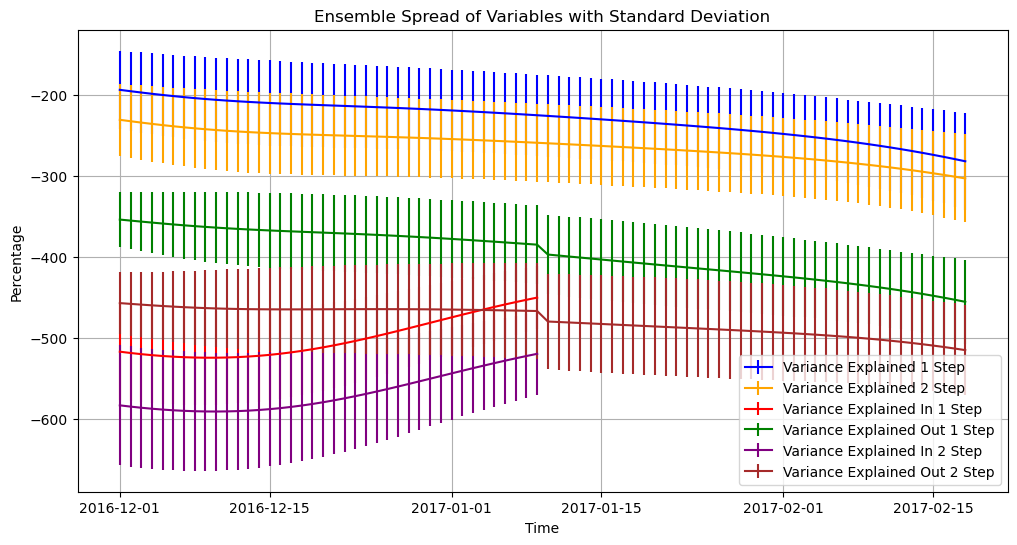

In [21]:
# Calculating the standard deviation over the 'sigma' dimension for each data array
select_sigma = 15
std_variance_explained_1step = np.std(variance_explained_1step[:, select_sigma], axis=(0)) / np.sqrt(12) # standard err of mean
std_variance_explained_2step = np.std(variance_explained_2step[:, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_in_1step = np.std(variance_explained_in_1step[:, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_out_1step = np.std(variance_explained_out_1step[:, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_in_2step = np.std(variance_explained_in_2step[:, select_sigma], axis=(0))/ np.sqrt(12)
std_variance_explained_out_2step = np.std(variance_explained_out_2step[:, select_sigma], axis=(0))/ np.sqrt(12)
std_rmse_over_rmssh = np.std(rmse_over_rmssh, axis=(0, 1))
std_ssh_est_skill2 = np.std(ssh_est_skill2, axis=(0, 1))
std_ssh_est_skill1 = np.std(ssh_est_skill1, axis=(0, 1))
std_err_est_skill1 = np.std(err_est_skill1, axis=(0, 1))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive']

# Plot each mean data array with its standard deviation
ax.errorbar(time_array, 100 - mean_variance_explained_1step[select_sigma]*100, yerr=std_variance_explained_1step*100, label='Variance Explained 1 Step', color=colors[0])
ax.errorbar(time_array, 100 - mean_variance_explained_2step[select_sigma]*100, yerr=std_variance_explained_2step*100, label='Variance Explained 2 Step', color=colors[1])
ax.errorbar(time_array, 100 - mean_variance_explained_in_1step[select_sigma]*100, yerr=std_variance_explained_in_1step*100, label='Variance Explained In 1 Step', color=colors[2])
ax.errorbar(time_array, 100 - mean_variance_explained_out_1step[select_sigma]*100, yerr=std_variance_explained_out_1step*100, label='Variance Explained Out 1 Step', color=colors[3])
ax.errorbar(time_array, 100 - mean_variance_explained_in_2step[select_sigma]*100, yerr=std_variance_explained_in_2step*100, label='Variance Explained In 2 Step', color=colors[4])
ax.errorbar(time_array, 100 - mean_variance_explained_out_2step[select_sigma]*100, yerr=std_variance_explained_out_2step*100, label='Variance Explained Out 2 Step', color=colors[5])

# Labels, title, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Percentage')
ax.set_title('Ensemble Spread of Variables with Standard Deviation')
ax.grid(True)
ax.legend()

# Display the plot
plt.show()


In [22]:
MSLA_fwrd_1step.shape

(12, 30, 40, 42, 80)

In [ ]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import build_swath, inversion, inversion2, make_error_over_time

day0, day1 = 0, 40 #
Tdim = day1 - day0
#time_range = 8 * (day1 - day0)
start_date = '2016-06-01' ## starting date
n_waves = '190' #number of waves
exp = 1 # P_over_R = K^-1
MModes = 1 # Rossby wave vertical modes

alpha_std = np.arange(5e-4, 3.05e-2, 1e-3) # standard deviation of error paramters

lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
date_time = avisso_ds.date_time.data[day0:]

wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date + '_' + n_waves + 'waves.nc') # forward model - filtered AVISO
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
Psi = strat_ds.Psi.data

k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

MSLA0 = MSLA_fwd[:, :, day0:day1]

### assess skill, get indices
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

M = l_n.size * k_n.size # Number of models/waves

dlon = lon - lon.mean()
dlat = lat - lat.mean()
    
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
omega = np.zeros([len(k_n), len(l_n), MModes])

nn = 0
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
            for count in range(len(Iindex)):
                # (data, model)
                H_cos[count, nn] = Psi[0, mm] * np.cos(l_n[ll, mm] * dlon[int(Iindex[count])] + k_n[kk, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
                H_sin[count, nn] = Psi[0, mm] * np.sin(l_n[ll, mm] * dlon[int(Iindex[count])] + k_n[kk, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
            nn += 1

H_all[:, 0::2] = H_cos
H_all[:, 1::2] = H_sin

# signal to noise ratio R_over_P

counter = 0
exp = -2
ssh_std = .1
k0 = k_n.max() # flat at or below k0

p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
counter = 0
R = 0.01 # noise = 1. cm

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp
        counter += 1

P_matrix = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(P_matrix[:],  R / p_diagonal / p_factor)

## build satellite swath

swath_width, x_swath = 6, 20
days = np.arange(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

rms_err, rms_ssh = np.zeros(len(alpha_std)), np.zeros(len(alpha_std))

ssh_est_skill2, err_est_skill2 = np.zeros(len(alpha_std)), np.zeros(len(alpha_std))

ssh_est_skill1, err_est_skill1 = np.zeros(len(alpha_std)), np.zeros(len(alpha_std))

# Loop over sigma
sigma_counter = 0
with tqdm(total= len(alpha_std)) as pbar:
    for sigma in alpha_std: # std of error amp

        # Add errors to the swaths
        mu = 0
        time_factor = np.arange(1, 1 + day1-day0)
        # generate error parameter with Gaussian distribution
        alpha = np.zeros([Tdim, 7]) #np.random.normal(mu, sigma, Tdim * 7).reshape(Tdim, 7) #
        for nn in range(7):
            alpha[:, nn] = np.random.normal(mu, sigma, Tdim) #TEST

        timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

        # sample SSH, errors and add white noise
        IND_TIMING = -7
        IND_ROLL = -6
        IND_BASELINE = -5
        IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

        #### Sub-sample the SSH, correlated errors and H matrix
        N = len(tindex) # number of data
        MSLA_swath = np.zeros(N)
        M = k_n.size * l_n.size
        nx, ny = len(lon), len(lat)
        H_swath = np.zeros([N, 2 * M + Tdim * 7]) # M: number of model
        IIndex = np.zeros(N) # N: Number of y data
        cor_err = np.zeros(N) # Correlated Error N: Number of y data
        Y_v = np.zeros(N)
        ssh = np.zeros(N)

        for ii in range(N):
            IIndex[ii] = nx * ny * tindex[ii] + ny * xvalid_index[ii] + yvalid_index[ii] # index in the vector space
            ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
            cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
            MSLA_swath[ii] = ssh[ii] + cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
            for nn in range(M):
                JIndex = 2 * MModes * nn # +  2 * mm # Model space
                H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
                H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

        Valid_points = len(xvalid_index) // Tdim
        err_basis_func = np.zeros([Valid_points, 7])
        for tt in range(Tdim):
            for ii in range(Valid_points):
                #timing error
                err_basis_func[ii, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
                # roll error = alpha[1] * Xc^1
                err_basis_func[ii, IND_ROLL] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
                # baseline dialation error = alpha[2] * Xc^2
                err_basis_func[ii, IND_BASELINE] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc
                # phase error
                H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
                H_pos = np.heaviside(xc1_valid[tt, ii], 1) #
                err_basis_func[ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
                err_basis_func[ii, IND_PHASE4] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
                err_basis_func[ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
                err_basis_func[ii, IND_PHASE6] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

        ### fill the error basis function part of the H matrix
        for tt in range(Tdim):
            #print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
            H_swath[tt*Valid_points:(tt+1)*Valid_points, 2 * M + tt * 7 : 2 * M + (tt+1) * 7] = err_basis_func

        counter = 0
        exp = -2
        ssh_std = .1
        k0 = k_n.max() # flat at or below k0
        p_diagonal = np.zeros([2 * M + Tdim * 7])
        kl, kl_plot = np.zeros(M), np.zeros(2*M)
        k_, l_ = np.zeros(M), np.zeros(M)
        counter = 0
        R = 0.01 # noise = 10. cm

        for kk in k_n:
            for ll in l_n:
                k_[counter] , l_[counter]  = kk, ll
                kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
                kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
                p_diagonal[2 * counter] = (kl[counter] + k0) ** exp  * p_factor
                p_diagonal[2 * counter + 1] = (kl[counter] + k0) ** exp  * p_factor
                counter += 1

        p_diagonal[2*M:] = sigma ** 2 # errors

        P_matrix = np.zeros([2 * M + Tdim * 7, 2 * M +  Tdim * 7])

        np.fill_diagonal(P_matrix[:],  R / p_diagonal )

        Y_vector = Y_v
        H_matrix = H_swath

        # 1-stage approach, solve for amplitudes
        amp_swath, msla_estimated_swath = inversion(MSLA_swath, H_swath, P_matrix) # assimilate the filtered AVISO SSH + error

        # estimate the errors and ssh : H * amp
        err_est_1step = np.matmul(H_matrix[:, -7*Tdim:], amp_swath[-7*Tdim:])
        ssh_est_1step = np.matmul(H_matrix[:, :-7*Tdim], amp_swath[:-7*Tdim])

        # Important result: error estimate skill and ssh estimate skill of the entire time series
        ssh_diff = ssh_est_1step - ssh
        err_diff = err_est_1step - cor_err
        ssh_diff1 = np.sqrt(np.mean(ssh_diff**2)) / np.sqrt(np.mean(ssh**2))
        err_diff1  = np.sqrt(np.mean(err_diff**2)) / np.sqrt(np.mean(cor_err**2))

        HTH = np.matmul(H_matrix[:, -7 * Tdim:].T, H_matrix[:, -7 * Tdim:])

        # Two-stage approach: reconstructing the SSH separately from solving the correlated error

        # First step: fit errors
        H_v1 = H_swath[:, -7 * Tdim:]
        P_over_R1 = P_matrix[-7* Tdim:, -7* Tdim:]
        HTH = np.matmul(H_v1.T, H_v1)
        HRH = HTH + P_over_R1 # P: uncertainty in model, R: uncertainty in data
        D = np.matmul(LA.inv(HRH), H_v1.T)
        amp_err = np.matmul(D, MSLA_swath)

        err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error

        # second step: fit residual to rossby wave models

        H_v = H_swath[:, :-7 * Tdim]
        HTH = np.matmul(H_v.T, H_v)
        HRH = np.zeros(HTH.shape)
        HRH = HTH +  P_matrix[:-7 * Tdim, :-7 * Tdim]
        D = np.matmul(LA.inv(HRH), H_v.T)
        eig, vec = LA.eig(HRH)

        # second step: fit residual to rossby wave models
        tau_ssh = MSLA_swath - err_est_2step
        amp_swath_2step = np.matmul(D, tau_ssh)
        ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days

        # Important result: 2-stage error estimate skill and ssh estimate skill
        ssh_diff = ssh_est_2step - ssh
        err_diff = err_est_2step - cor_err
        ssh_diff_2stage = np.sqrt(np.mean(ssh_diff ** 2)) / np.sqrt(np.mean(ssh ** 2))
        err_diff_2stage = np.sqrt(np.mean(err_diff ** 2)) / np.sqrt(np.mean(cor_err ** 2))
        
        # Root mean squared err/ssh
        rms_err[sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
        rms_ssh[sigma_counter]= np.sqrt(np.mean(ssh ** 2))

        # Important result: 2-stage error estimate skill and ssh estimate skill
        ssh_est_skill2[sigma_counter], err_est_skill2[sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,

        # Important result: 1-stage error estimate skill and ssh estimate skill
        ssh_est_skill1[sigma_counter], err_est_skill1[sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 # percentage,

        sigma_counter += 1
        
        pbar.update(1)

100%|███████████████████████████████████████████| 30/30 [03:22<00:00,  6.75s/it]


In [ ]:
rmse_over_rmssh = rms_err / rms_ssh
rmse_over_rmssh

array([0.06001275, 0.1584853 , 0.3316141 , 0.39414852, 0.62612566,
       0.59340929, 0.70204538, 0.86996086, 0.87175052, 0.99586669,
       1.22068686, 1.42878299, 1.41344863, 1.58748196, 1.48338411,
       1.6486218 , 2.15643207, 1.97801318, 2.19045562, 2.2447999 ,
       2.53545988, 2.77786237, 3.06802671, 3.13451092, 3.06095578,
       3.0512409 , 2.9152323 , 3.24151622, 3.42005934, 3.53649186])

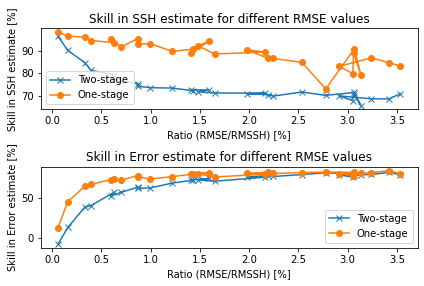

In [6]:
import matplotlib.pyplot as plt

# Create subplots

fig, axs = plt.subplots(2)

# Plot data
axs[0].plot(rmse_over_rmssh, ssh_est_skill2, '-x', label='Two-stage')
axs[0].plot(rmse_over_rmssh, ssh_est_skill1, '-o', label='One-stage')

axs[1].plot(rmse_over_rmssh, err_est_skill2, '-x', label='Two-stage')
axs[1].plot(rmse_over_rmssh, err_est_skill1, '-o', label='One-stage')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH) [%]')
axs[0].set_ylabel('Skill in SSH estimate [%]')
axs[1].set_xlabel('Ratio (RMSE/RMSSH) [%]')
axs[1].set_ylabel('Skill in Error estimate [%]')

# Add titles
axs[0].set_title('Skill in SSH estimate for different RMSE values')
axs[1].set_title('Skill in Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()
plt.show()
